# 链接仪器

In [8]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab import wavepoint
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [9]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
#ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [ ]:
await psg103.setValue('Frequency',2.5e9)

# qubit工作点

In [3]:
freqall = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}
atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=-0.024,f_ex=2*6.3e9+2e6,power_ex=-2.27) #power=-2.1

## 保存工作点

In [ ]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

## 提取工作点

In [4]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0331\QubitState\qubitstate_20200331220551.npz


# 指定仪器

In [10]:
psg_lo = psg104
psg_ex1 = psg105
psg_ex2 = psg106
psg_ex3 = psg230
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

## 测量类

In [5]:
measure = mr.common(freqall,ats,dc,psg,awg_list,jpa)

In [7]:
await mr.awgSync(measure)

# 信号检查

In [6]:
delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
await mr.modulation_read(measure,delta,tdelay=1500)
await mr.ats_setup(ats,delta,l=1500)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])

## 复平面信号

In [ ]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=True,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


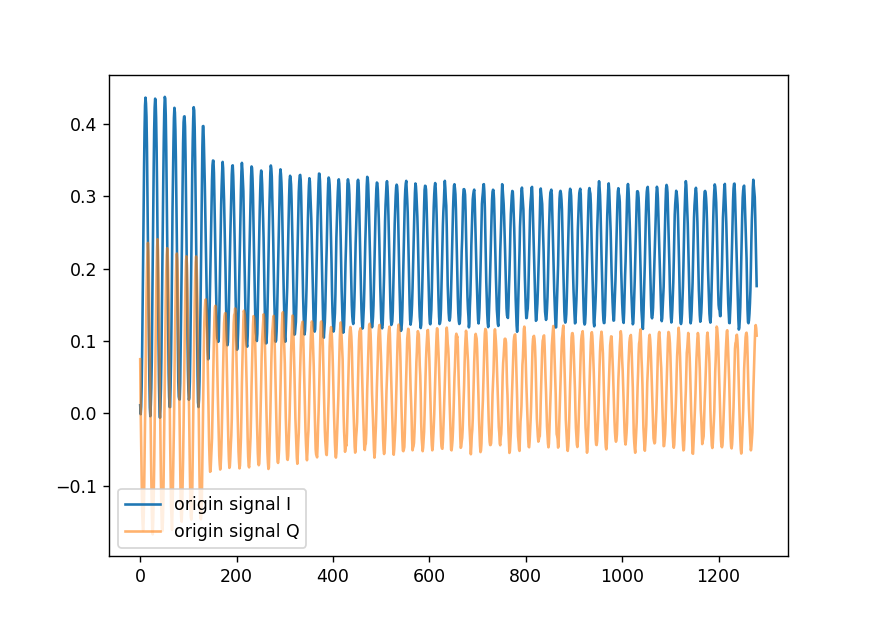

In [441]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex2'].setValue('Output','OFF')
for i in range(1):
    chA, chB = await ats.getTraces()
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


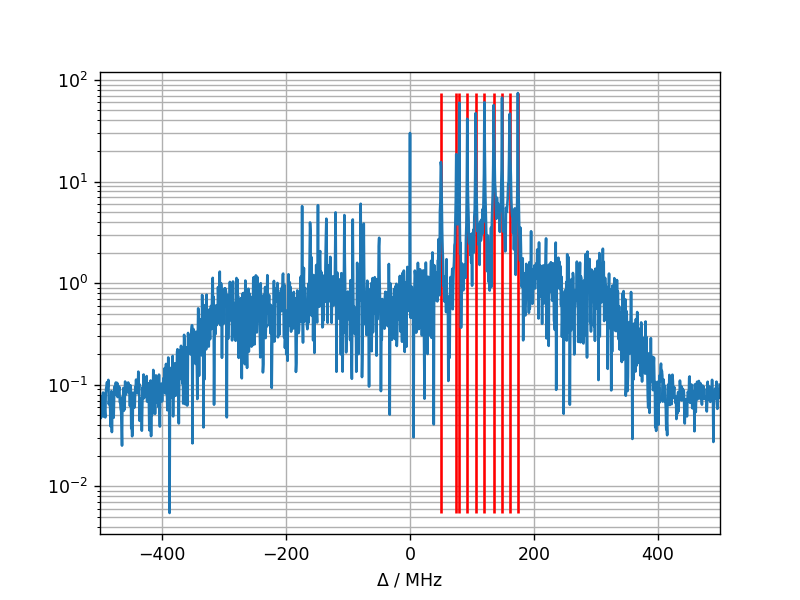

In [180]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

# 仪器状态

In [11]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=['awg131','awg132','awg133','awg134'])

In [12]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,+0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.750000GHz,3.945000GHz,3.945000GHz,4.000000GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0
offset,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000dBm,-5.000000dBm,15.000000dBm,10.000000dBm,-2.270000dBm


In [500]:
await mr.RecoverInst(measure)

In [192]:
await mr.modulation_ex(q_target,measure)

In [190]:
await psg_ex1.setValue('Moutput','OFF')

In [199]:
await psg_ex1.setValue('Frequency',6.55e9)

In [18]:
await psg_lo.setValue('Power',18)

# S21

In [10]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10],q_target='q3')

com7 open...
DS Instruments,DAT64H,410,V9.07
last ATT 13.0
now ATT 13.0


Output()

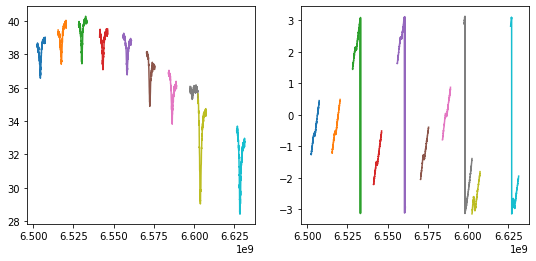

In [11]:
q_target = qubits
tag = q_target.q_name
att_setup = mr.Att_Setup('com7')
att_setup.Att(13)
await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
await mr.jpa_switch(measure,state='ON')
job = Job(mr.S21, (q_target,measure,True), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [19]:
await awg133.query('syst:err?')

'0,"No error"\n'

# S21vsFlux

In [ ]:
current = np.linspace(-1.5,1.5,21)
bits = [q2,q3,q4,q5]
#await dc[bis[0].inst['dc']].DC(1)
for i in bits[1:2]:
    tag = i.q_name
    print(tag)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    qubits = mr.qubitCollections(bits)
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux_awgoffset, (qubits,measure,current,calimatrix[1:5,1:5],True), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    #await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0401/crosstalk_cali/xue_crosstalk_q2_5_20200401211425.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [ ]:
calimatrix[1:5,1:5]

# S21vsPower

In [ ]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

<IPython.core.display.Javascript object>


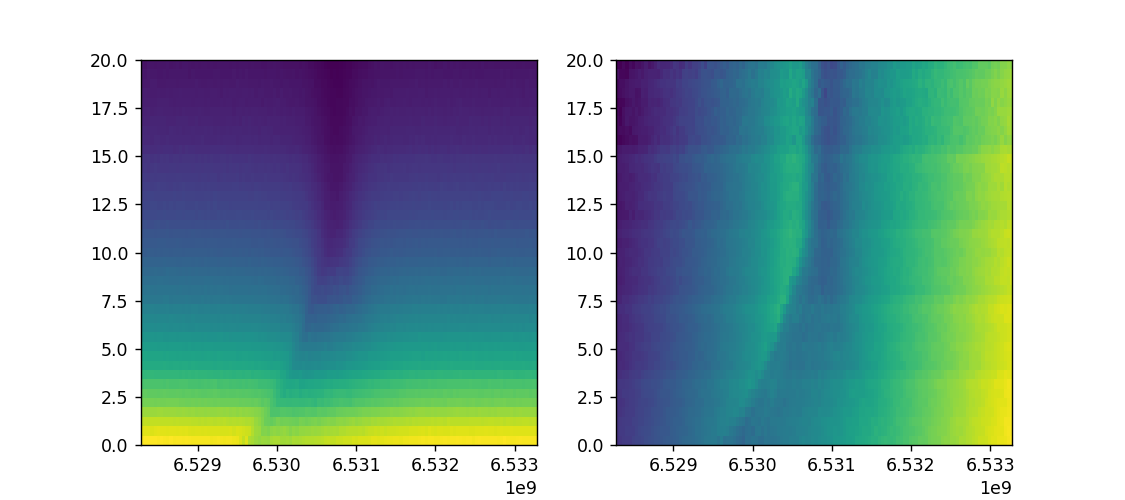

In [326]:
q_target, att = q3, np.linspace(0,20,41)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com7',True), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [12]:
# await dc[q6.inst['dc']].DC((q6.T_bias[0]/2+q6.T_bias[1]))
# await dc[q4.inst['dc']].DC((q4.T_bias[0]/2+q4.T_bias[1]))
# await dc[q1.inst['dc']].DC((q1.T_bias[0]/2+q1.T_bias[1]))
# await dc[q5.inst['dc']].DC((q5.T_bias[0]/2+q5.T_bias[1]))
x = sy.Symbol('x')
q_target = qubits
# zname, zch = [''.join((q_target.q_name,'_z'))], q_target.inst['z_ch']
# await measure.awg[q_target.inst['z_awg']].create_waveform(name=zname[0], length=250000, format=None) 
# await cw.zWave( measure.awg[q_target.inst['z_awg']],zname,zch,0)
att_single, bias = q_target.power_ex, -0.05
f_com = np.float(q_target.specfunc.evalf(subs={x:bias}))
print(round(f_com,3))
# await mr.RecoverInst(measure,state=q_target.state[0])
# init = [bias if q_target==j else j.T_bias[1]-j.T_bias[0]*0.5 for j in [q2,q3,q4,q5]]
# clist = np.mat(calimatrix[1:5,1:5]).I * np.mat(init).T 
# for k, j in enumerate(clist,start=2):
#     await measure.dc[globals()['q%d'%k].inst['dc']].DC(j[0,0])

3.745


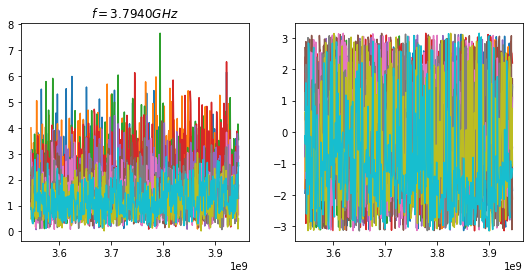

In [15]:
tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
# freq = np.arange(3.6,4,0.001)*1e9
await psg_ex1.setValue('Power',-5)
await dc[q_target.inst['dc']].DC(bias)
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex)
#await psg[q_target.inst['ex_lo']].setValue('Power',0)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
#await psg_ex1.setVal6e('Output','OFF')
await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True), tags=[tag], max=len(freq))
f_ss, s_ss = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss,np.abs(s_ss))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[eval(q_target.q_name[1:])-1]/1e9))
axes[1].plot(f_ss,np.angle(s_ss))
plt.show()

In [336]:
q3 = q3._replace(bias=bias,f_ex=np.array([3.745e9]),state=[state,measure.delta,measure.base,measure.readlen])

In [229]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.1, zpulse=None, f_lo=array([6.53078e+09]), delta=array([50000000.]), f_ex=array([3.886e+09]), delta_ex=array([0]), power_ex=30, power_rabi=13, pi_len=25.1, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': -0.1, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 1.0525, 'load': 'high Z'}, 'dc15': {'offset': 0.0, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.580780GHz', 'power': '13.000000dBm', 'output'

In [337]:
q3 = q3._replace(inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg133', 'ex_ch': [3,4], 'ex_lo': 'psg_ex1', 'com': 'com12'},delta_ex=np.array([80e6]),power_ex=60)

## 单条谱扫电压

In [ ]:
tag, ftarget, biaslist = q_target.q_name, 3.75e9, np.arange(-0.02,0.02,0.001) + bias

att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# Rabi

In [338]:
q_target = q3
if q_target.inst['ex_lo'] == 'psg_ex2':
    t_rabi = np.linspace(5,105,201)
    att_single = 4
    await psg_ex1.setValue('Output','OFF')
else:
    t_rabi = np.linspace(1,101,201)
    att_single = 20
    await psg_ex2.setValue('Output','OFF')
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence_rabi')))
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
await mr.RecoverInst(measure,state=q_target.state[0])
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

com12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 60.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


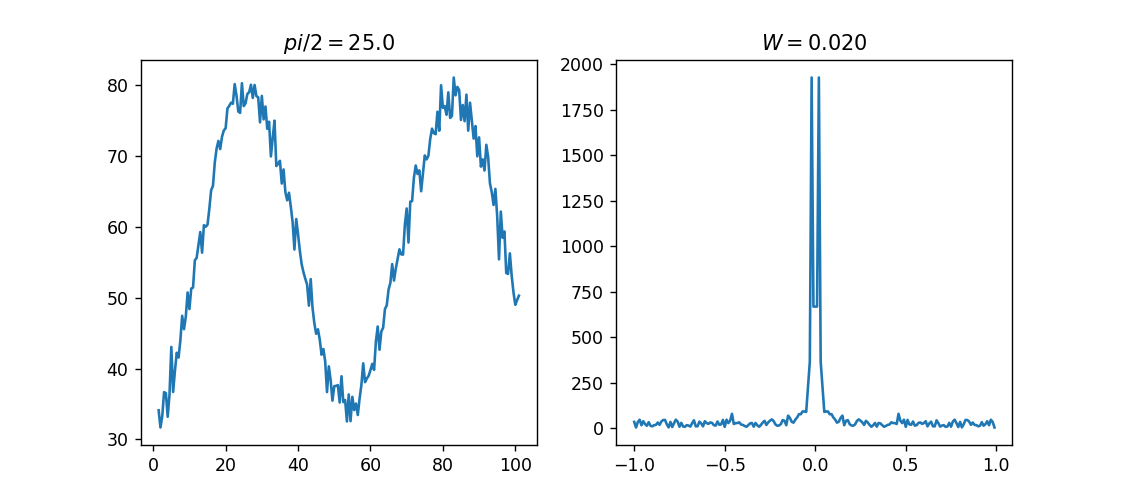

In [339]:
tag = q_target.q_name
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(att_single)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
await mr.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)-1),awg=1)
job = Job(mr.rabi, (q_target,measure,t_rabi,(len(t_rabi)-1),True), tags=[tag], max=500,avg=True)
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
# index = np.abs(s_r).argmax(axis=0)
# t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
x, y = t_r[:,0], np.abs(s_r[:,0])
t_op = op.RowToRipe().firstMax(x,y,num=0)
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [342]:
q3 = q3._replace(pi_len=t_op,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

In [ ]:
await mr.RecoverInst(measure,state=q3.state[0])

In [ ]:
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op

# rabiPower

com13 open...
DS Instruments,DAT64H,372,V9.10
last ATT 10.0
now ATT 05.0


Output()

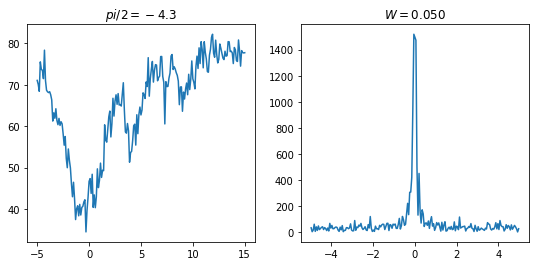

In [117]:
att, q_target = np.linspace(-5,15,201), q5

mr.Att_Setup(q_target.inst['com']).Att(5)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPower, (q_target,measure,att), tags=[tag], max=len(att))
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op = op.RowToRipe().firstMax(t_r[:,0],np.abs(s_r[:,0]),num=0)
sample = (np.max(t_r[:,0]) - np.min(t_r[:,0]))/(len(t_r[:,0]) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(s_r[:,0]))) / sample
amp = np.fft.fftshift(np.fft.fft(s_r[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [ ]:
q3 = q3._replace(pi_len=20,power_rabi=t_op,state=[state,measure.delta,measure.base,measure.readlen])

# Readout point

com12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


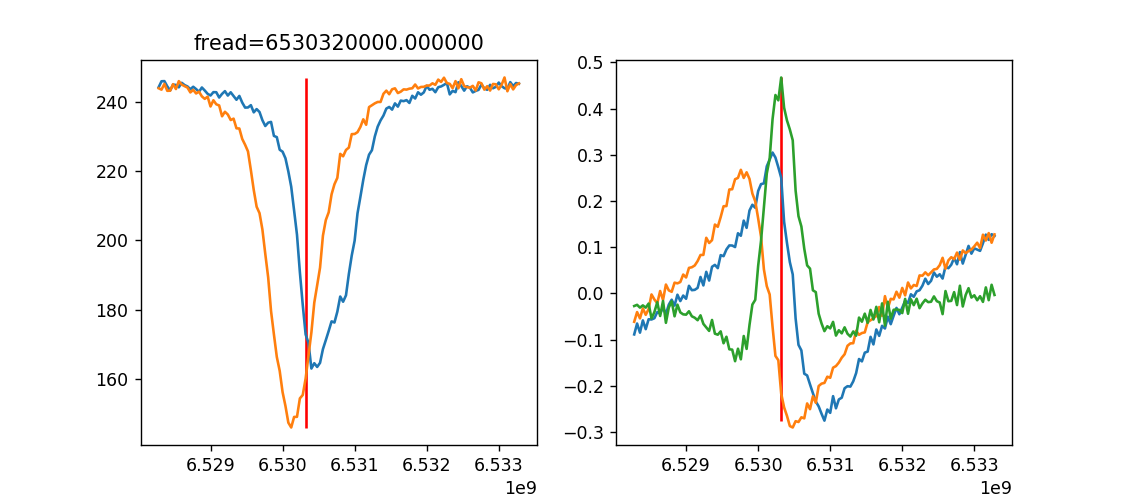

In [343]:
q_target = q3
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_rabi)
job = Job(mr.readOp, (q_target,measure,True), tags=[tag], max=2)
st, f_op, s_op = await job.done()
f, s_off, s_on = f_op[:,:,0][0], s_op[:,:,0][0], s_op[:,:,0][1]
x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
index = np.abs(anglediff).argmax(axis=0)
#index = np.abs(s_off).argmin(axis=0)
f_lo = f[index]
measure.f_lo = np.array([f_lo])
await psg['psg_lo'].setValue('Frequency',(f_lo+measure.delta[0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_op[:,:,0].T,np.abs(s_op[:,:,0].T))
axes[0].set_title('fread=%f'%f_lo)
axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,0].T)),np.min(np.abs(s_op[:,:,0].T)),'r')
axes[1].plot(x_off,np.angle(y_off[0]))
axes[1].plot(x_on,np.angle(y_on[0]))
axes[1].plot(x_off,anglediff)
axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()

# 优化读出长度

com7 open...
DS Instruments,DAT64H,410,V9.07
last ATT 16.0
now ATT 15.0


Output()

<IPython.core.display.Javascript object>


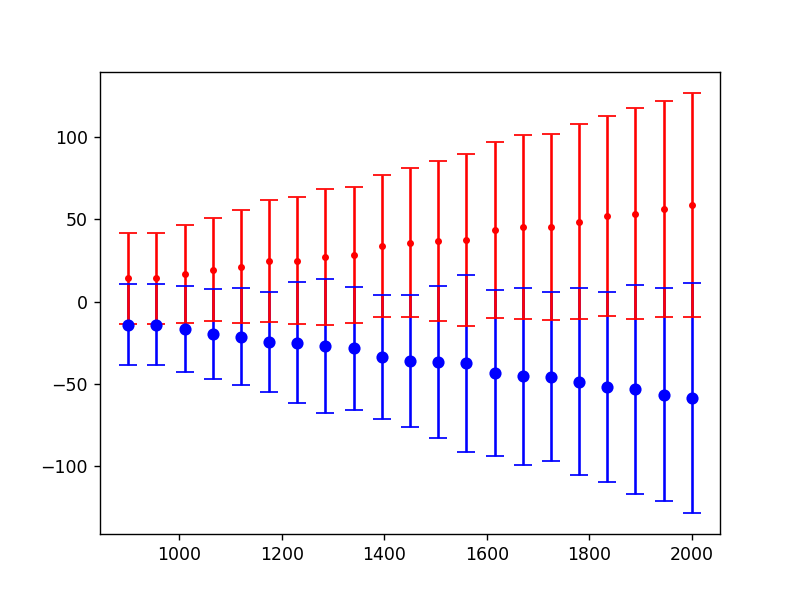

In [361]:
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(15)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

In [ ]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

com7 open...
DS Instruments,DAT64H,410,V9.07
last ATT 15.0
now ATT 15.0


Output()

<IPython.core.display.Javascript object>


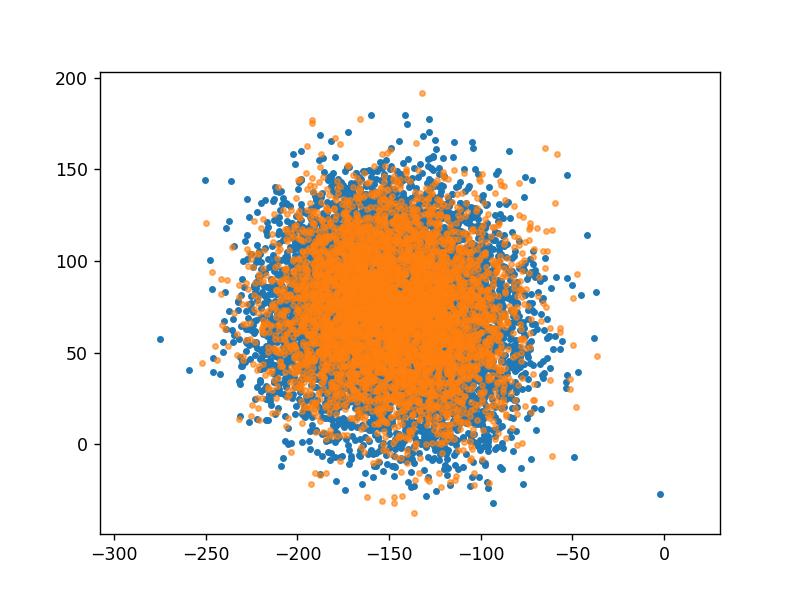

In [507]:
q_target = q3
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(15)
job = Job(mr.threshHold, (q_target,measure,True), tags=[tag], max=2)
st, s_st = await job.done()
s_off, s_on = s_st[0][:,0], s_st[1][:,0]
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

In [470]:
x, y = s_st[0][:,0], s_st[1][:,0]
offmean, onmean = np.mean(x), np.mean(y)
offstd, onstd = np.std(x), np.std(y)
theta = np.arange(0, 2*np.pi, 0.01)
roff = np.real(offmean) + offstd * np.cos(theta)
ioff = np.imag(offmean) + offstd * np.sin(theta)
ron = np.real(onmean) + onstd * np.cos(theta)
ion = np.imag(onmean) + onstd * np.sin(theta)
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(roff,ioff)
ax[0].plot(ron,ion)
plt.show()

<IPython.core.display.Javascript object>


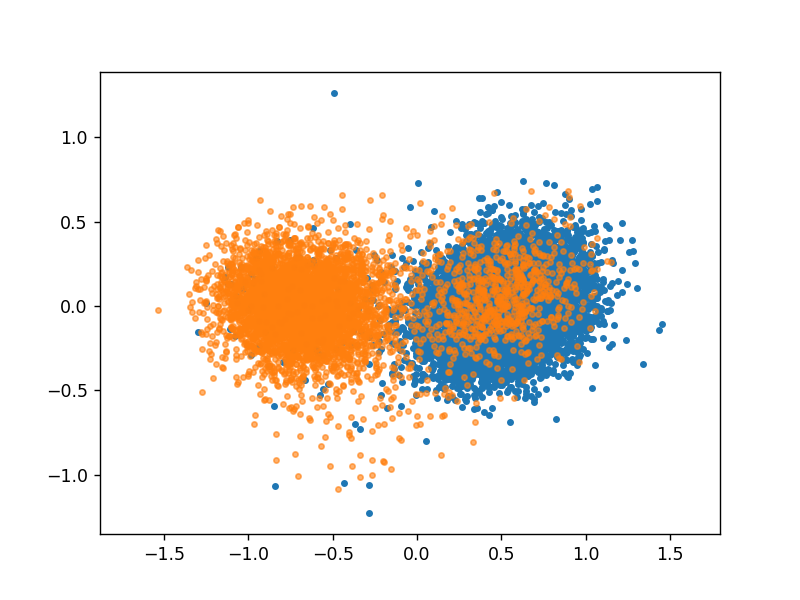

In [476]:
%matplotlib notebook
x, y = s_st[0][:,0], s_st[1][:,0]
add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
s_off, s_on = (x-add)/diff, (y-add)/diff
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

0.35088832487309646


<IPython.core.display.Javascript object>


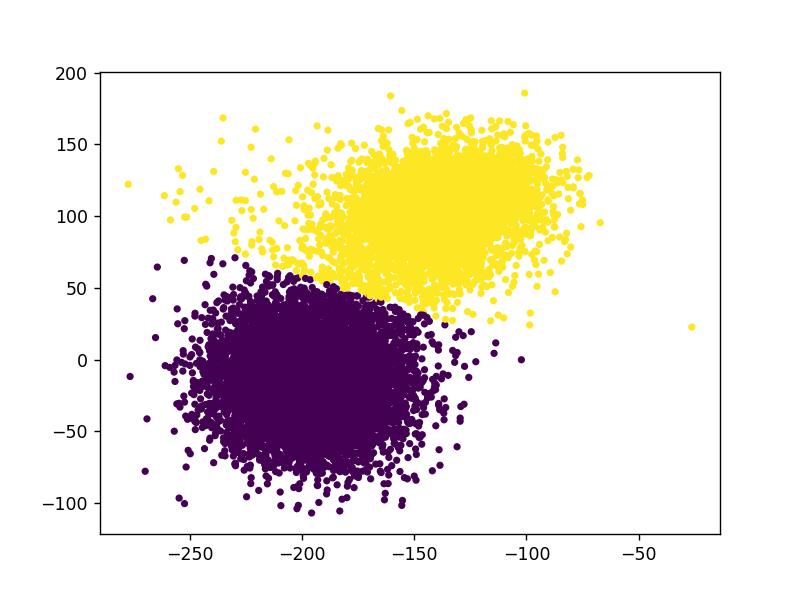

In [471]:
S = list(s_off) + list(s_on)
S = np.array(S)
x,z = np.real(S), np.imag(S)
d = list(zip(x,z))
d = np.mat(d)
kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
kmeans.fit(d)
measure.predict = kmeans.predict
y = kmeans.predict(d)
print(list(y).count(1)/len(y))
plt.figure()
plt.scatter(x,z,c=y,s=10)
plt.show()

0.975635593220339


<IPython.core.display.Javascript object>


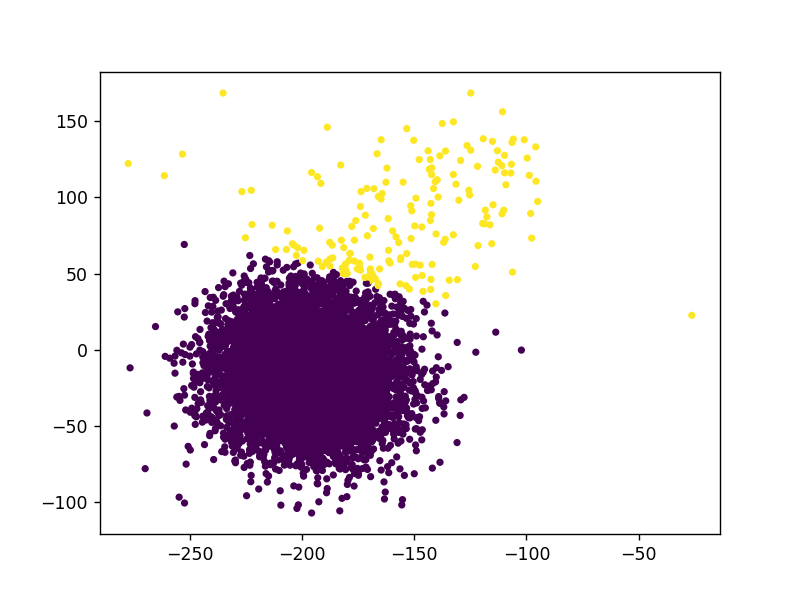

In [473]:
ss, which = s_off, 0
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

Output()

<IPython.core.display.Javascript object>


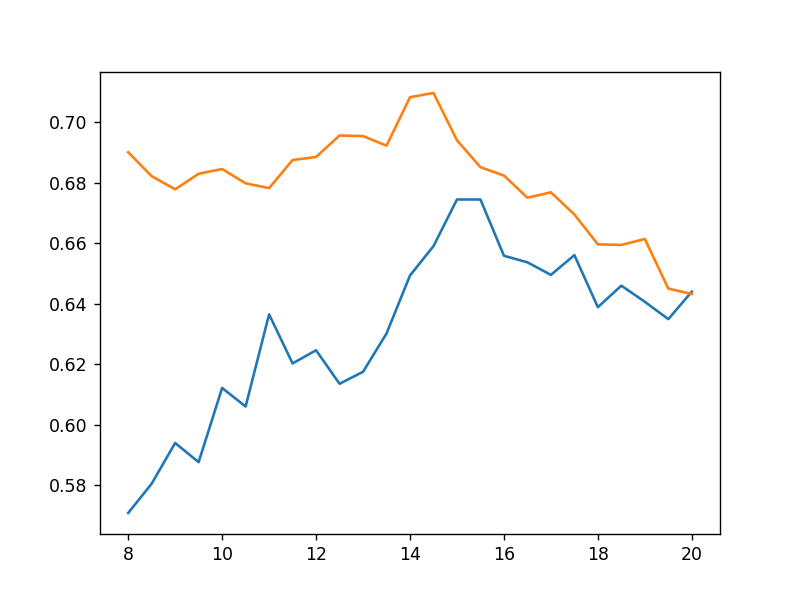

In [367]:
com, att = 'com7', np.linspace(8,20,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
attopt, popoff, popon = await job.done()
plt.figure()
plt.plot(attopt,popoff)
plt.plot(attopt,popon)
plt.show()

# pi脉冲优化

<IPython.core.display.Javascript object>


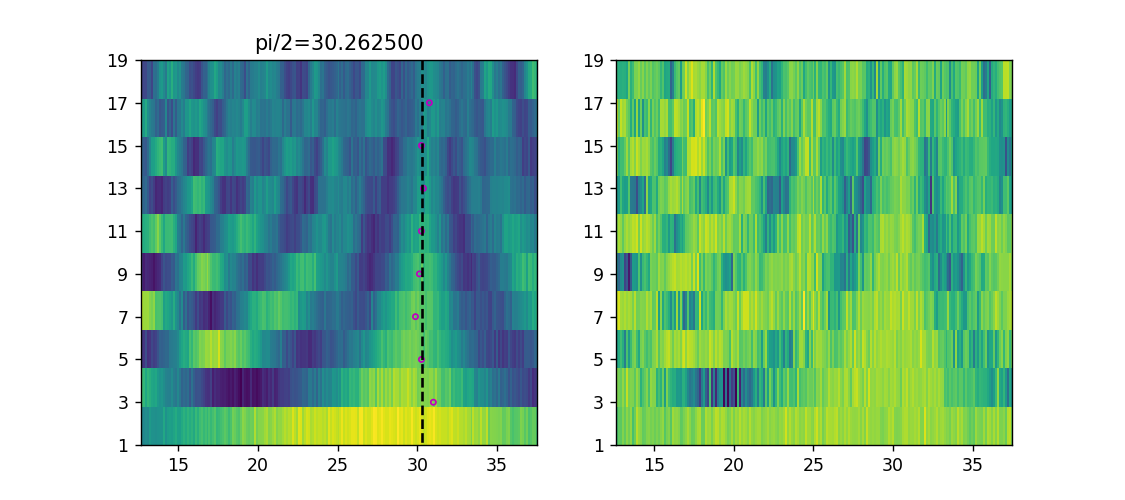

In [499]:
# q_target, nwave, wavlen = q3, 10, len(t_rabi)
# tag = q_target.q_name
# job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
# n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
y = np.array([op.RowToRipe().firstMax(y,z,num=30,peakpercent=0.7) for z in s])
axes[0].scatter(y[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(y),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(y))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s_pi[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

In [492]:
help(plt.xticks)

Help on function xticks in module matplotlib.pyplot:

xticks(ticks=None, labels=None, **kwargs)
    Get or set the current tick locations and labels of the x-axis.
    
    Call signatures::
    
        locs, labels = xticks()            # Get locations and labels
        xticks(ticks, [labels], **kwargs)  # Set locations and labels
    
    Parameters
    ----------
    ticks : array_like
        A list of positions at which ticks should be placed. You can pass an
        empty list to disable xticks.
    
    labels : array_like, optional
        A list of explicit labels to place at the given *locs*.
    
    **kwargs
        :class:`.Text` properties can be used to control the appearance of
        the labels.
    
    Returns
    -------
    locs
        An array of label locations.
    labels
        A list of `.Text` objects.
    
    Notes
    -----
    Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
    equivalent of calling `~.Axes.get_xticks` and `

In [414]:
q3 = q3._replace(pi_len=np.mean(y),power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

In [420]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex1', 'com': 'com12'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.05, zpulse=None, f_lo=array([6.53078e+09]), delta=array([50000000.]), f_ex=array([3.745e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=20, pi_len=30, T1=23016.178849233776, state=[{'dc01': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': -0.024, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.05, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc15': {'off

# AC-Stark

In [ ]:
t_ac, q_target = np.linspace(2500,4500,51), q4
job = Job(mr.acStark, (q_target,measure,t_ac), tags=[tag], max=len(t_ac))
t_AC, f_AC, s_AC = await job.done()
# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC))
# plt.show()

In [ ]:
q7 = q7._replace(inst={'dc': 'dc08', 'z_awg': 'awg131', 'z_ch': 7, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'})

In [ ]:
q6

## ZPulse与激励时序

In [ ]:
t_z, q_target = np.linspace(500,2500,51), q6
measure.delta,measure.base,measure.readlen = q_target.state[1:]
await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.zPulse, (q_target,measure,t_z), tags=[tag], max=len(t_z))
t_AC, f_AC, s_AC = await job.done()

## 单条

In [ ]:
t_z, q_target = np.linspace(500,2500,501), q3
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.zPulse_pop, (q_target,measure,t_z), tags=[tag], max=len(t_z))
t_AC, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_AC[:,0],np.abs(pop[:,0]))
plt.show()

In [ ]:
np.savez(r'C:\Users\23967\Desktop\spec\z-pulse.npz',x=t_AC[:,0],y=np.abs(pop[:,0]))

# T1

Output()

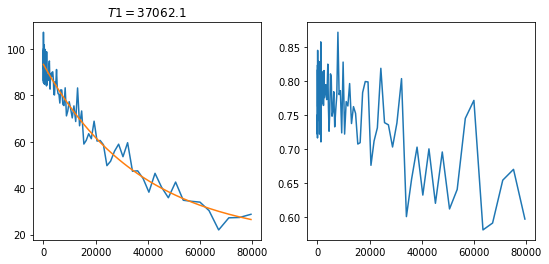

In [47]:
t_T1, q_target = np.logspace(0,4.9,201,endpoint=True), q3
await psg_ex1.setValue('Moutput','OFF')
job = Job(mr.T1, (q_target,measure,t_T1,(len(t_T1)-1),False), tags=[tag], max=500,avg=True)
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]/T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1f$'%T1)
axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [ ]:
q1 = q1._replace(T1=T1)

In [41]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.15, zpulse=None, f_lo=array([6.53062e+09]), delta=array([50000000.]), f_ex=array([3.714e+09]), delta_ex=array([0]), power_ex=30, power_rabi=4, pi_len=15.0, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': -0.024, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.15, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0525, 'load': 'high Z', 'error': '+0'}, 'dc15': {'offset

# Ramsey

In [70]:
t_Ramsey, q_target = np.linspace(0,5000,201), q3
# if q_target.inst['ex_lo'] == 'psg_ex2':
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex+3e6)[0])
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_Ramsey),['Readout_Q']*len(t_Ramsey)]

Output()

(54.508717343800214, 95.0939348455207, 20000, 1092.0919469546088, 0.0062, 0)


<IPython.core.display.Javascript object>


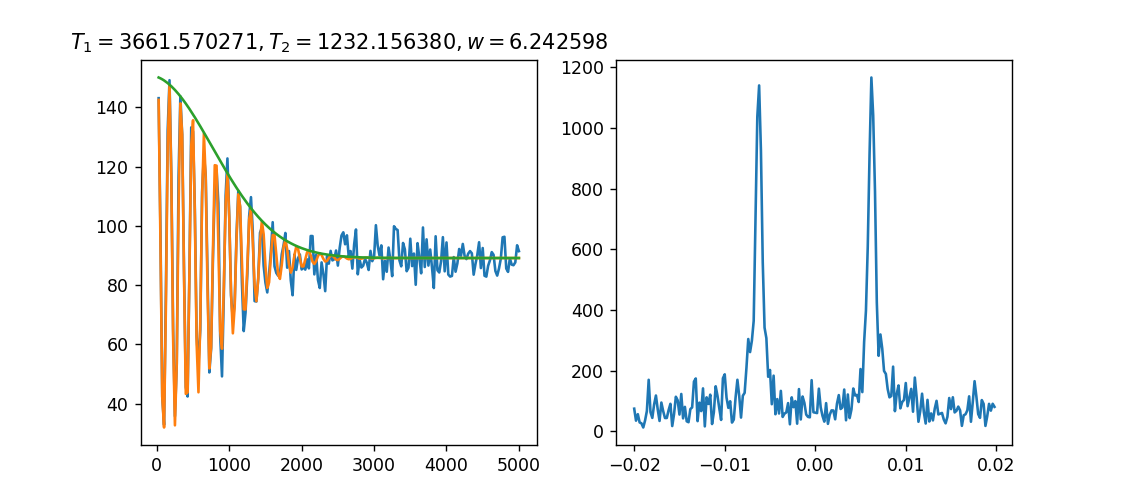

In [71]:
%matplotlib notebook
await psg_ex1.setValue('Moutput','ON')
# mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
#await psg[q_target.inst['ex_lo']].setValue('Power',q_target.power_rabi)
job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,(len(t_Ramsey)-1),True), tags=[tag], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], s_ram[:,0]
A,B,T1,T2,w,phi = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [ ]:
4.18204-3.68342

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
# axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [ ]:
f = np.array([3.805,3.978,3.602,3.762,3.992,3.859,3.616,3.965,3.685,3.663])
df = np.array([0.41499,0.10439,0.59453,0.34952,0.08163,0.24785,0.56559,0.10131,0.39304,0.32317])*1e3
f_center = np.array([3.37939,3.29674,2.20569,2.98343,3.16597,2.8314,5.49745,4.77655,4.18204])*1e3
plt.figure()
plt.plot(f,df,'o')
plt.ylabel('$\Delta \omega(KHz)$')
plt.xlabel('$\omega (GHz)$')
plt.show()

In [ ]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [78]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex1', 'com': 'com12'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.15, zpulse=None, f_lo=array([6.53062e+09]), delta=array([50000000.]), f_ex=array([3.714e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=23, pi_len=19.0, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': -0.024, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.15, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0525, 'load': 'high Z', 'error': '+0'}, 'dc15'

# SpinEcho

In [76]:
t_spin, q_target = np.linspace(0,10000,201), q3
# if q_target.inst['ex_lo'] == 'psg_ex2':
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_spin),['Readout_Q']*len(t_spin)]

Output()

(5.766125714115891, 9.938006493252407, 20000, 36343.81559922378, 0.0096, -1.5707963267948966)


<IPython.core.display.Javascript object>


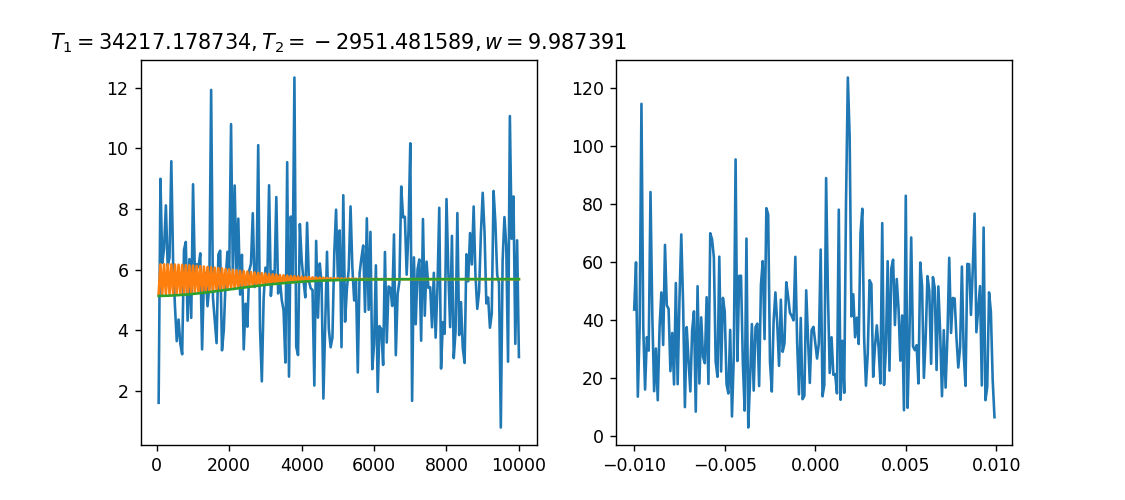

In [81]:
await psg_ex1.setValue('Moutput','ON')
# mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
#await psg[q_target.inst['ex_lo']].setValue('Power',q_target.power_rabi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.SpinEcho, (q_target,measure,t_spin,(len(t_spin)-1),1,'CPMG',False), tags=[tag], max=500,avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_sp,np.abs(s_sp))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 普矫正

In [ ]:
v_rabi = np.linspace(-0.04,0.04,201)
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len(v_rabi),['Readout_Q']*len(v_rabi)]

In [ ]:
bits = [q2,q3,q4,q5]
count = 0
for v, k in enumerate(bits):
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_ex)
    await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.crosstalkSpec, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await mr.InitInst(measure,psgdc=False,awgch=True)
            count += 1
    await mr.InitInst(measure,psgdc=True,awgch=True)

In [ ]:
measure.n = 1

# 二维谱

In [ ]:
freq = np.arange(3.45,4.05,0.001)*1e9
bits = [q2,q3,q4,q5]
for i in bits[1:2]:
    att_setup = mr.Att_Setup(i.inst['com'])
    att_setup.Att(i.power_ex)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    print(i.q_name)
    init = [1 if i.q_name==j else 0 for j in ['q2','q3','q4','q5']]
    qubits = mr.qubitCollections(bits)
    job = Job(mr.spec2d, (qubits,measure,freq,calimatrix[1:5,1:5],init,True), tags=[i.q_name], max=31)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

In [ ]:
q3.T_bias

# RB 

In [474]:
mlist, q_target, len_data = np.logspace(0.4,2.5,21,dtype=int), q3, 31
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len_data,['Readout_Q']*len_data]

In [475]:
job = Job(mr.RB, (q_target,measure,mlist,len_data,True), tags=[tag], max=len(mlist))
n_RB, s_RB = await job.done()

Output()

In [477]:
pop = []
for j in range(np.shape(s_RB)[0]):
    s = np.array(s_RB[j])
    pm = []
    for i in range(np.shape(s)[1]):
        d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
        y = measure.predict(d)
        pm.append(list(y).count(0)/len(y))
    pop.append(pm)

<IPython.core.display.Javascript object>


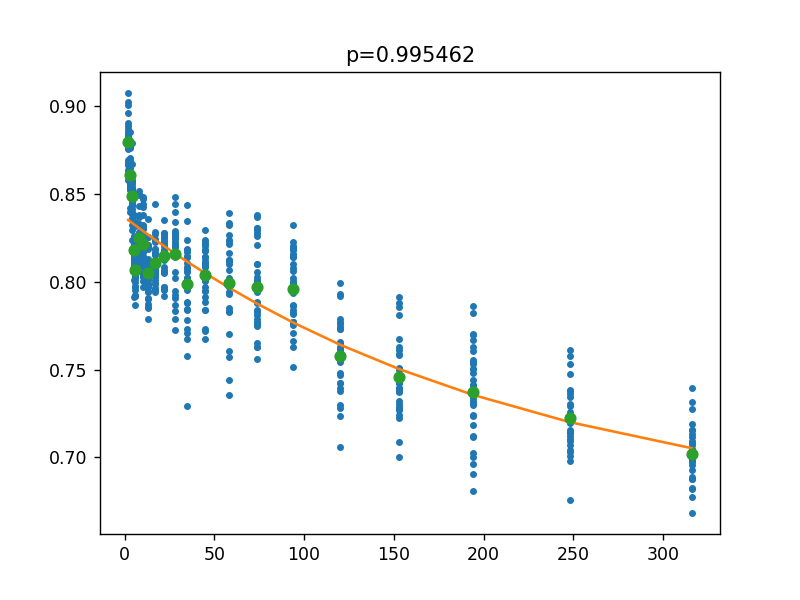

In [478]:
#n_RB = [1,5,10,20,50,100,150]
x = np.meshgrid(range(np.shape(pop)[1]),n_RB)[1]
plt.figure()
plt.plot(x.flatten(),np.array(pop).flatten(),'.')
plt.show()

In [479]:
def err(paras,x,y):
    A,B,p = paras
    return A*p**x+B-y
def guess(x,y):
    B = np.min(y)
    y = y - np.min(y)
    mask = y > 0
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return np.exp(np.abs(a[1])), B, 1/np.exp(np.abs(a[0]))

In [480]:
x, y = n_RB, np.abs(np.mean(pop,axis=1))
p0 = guess(x,y)
res = ls(err, p0, args=(x, y)) 
A,B,p = res.x
fig = plt.gcf()
ax = plt.getp(fig,'axes')
z = A*p**x+B
ax[0].plot(x,z)
ax[0].plot(x,y,'o')
ax[0].set_title('p=%f'%p)
plt.show()

In [ ]:
i = 20
s = np.array(s_RB[0])
d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s[:,i]),np.imag(s[:,i]),c=y,s=10)
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(n_RB,np.abs(s_RB[:,:,0].mean(axis=1)))
axes[1].plot(n_RB,np.angle(s_RB[:,:,0].mean(axis=1)))
plt.show()

In [ ]:
qubits = qubitCollections([q1,q2])

In [ ]:
qubits.qubitExecute(state={'q1':{'dc':0.1,'ex':1,'read':True},'q2':{'dc':0.2,'ex':1,'read':True}})

In [ ]:
qubits.qall

In [ ]:
qubits.qstate

In [ ]:
q1

In [ ]:
x = {}
for i in x:
    print(x[i])

In [ ]:
async def sub_seq(awg,name_w):
    name_s = ''.join(('sub_',name_w))
    await awg.create_sequence(name_s,2,1)
    await awg.set_seq(wave_name=name_w,step=1,track=1,seq_name=name_s,
                          wait='OFF',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
    await awg.set_seq(wave_name='zero',step=2,track=1,seq_name=name_s,
                          wait='OFF',goto='FIRST',repeat='195',jump0='OFF',jump1='FIRST')
    return name_s

In [ ]:
async def wave(awg,name_seq,w):
    y, j = np.linspace(-150,50,101), 0
    len_s = len(y)
    await awg.create_sequence(name_seq,len_s,1)
    wf = WF(t_list)
    for k in tqdm(y,ncols=1,desc='sequence'):
        j += 1
        name_w, name_seq, track = ''.join(('Ex_Q_5_','%d'%j)), name_seq, 1
        if k == 0 :
            beta = np.inf
        else:
            beta = w/k  
        #c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3]
        t = np.sqrt(k**2+w**2)   
        theta = np.arctan(beta)
        f,phi,height,t_end,width = [delta_ex,delta_ex],[[np.pi/2],[np.pi/2+theta]],[[1],[1]],[[2800-t],[2900]],[[pi_len/2],[t]]
        sample = wf.sin_envelope(f,phi,t_end,width,height)
        #await awg.remove_waveform(name=name_w)
        #await awg.remove_sequence(name=''.join(('sub_',name_w)))
        await awg.create_waveform(name=name_w, length=len(t_list), format=None)
        await awg.update_waveform(sample,name=name_w)
        name_s = await sub_seq(awg,name_w)
 

        if j == len_s:
            jump1 = 'FIRST'
        else:
            jump1 = 'NEXT'
        await awg.set_seq(wave_name=name_s,step=j,track=track,seq_name=name_seq,tag='subseq',
                            wait='ATR',goto='NEXT',repeat='INFinite',jump0='BTRigger',jump1=jump1)